# Zadanie 3 (7 punktów)

Celem ćwiczenia jest imlementacja metody [Minimax z obcinaniem alpha-beta](https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning) do gry  Czwórki (ang. Connect Four).

W trakcie ćwiczenia można skorzystać z reposytorium z implementacją gry [Connect Four udostępnionym przez Jakuba Łyskawę](https://github.com/lychanl/two-player-games). Ewentualnie, można zaimplementować samemu grę Connect Four.

Należy zaimplementować co najmniej dwie heurystyki do ewaluacji planszy.  

Implementację algorytmu Minimax (klasa `MiniMaxSolver`) należy przetestować używając różną głębokość przeszukiwania symulując grę "komputer vs komputer". W eksperymentach należy również zademonstrować różnice pomiędzy heurystykami.  

W ramach zadania można zaimplementować dowolną liczbę dodatkowych metod w klasie `MiniMaxSolver`.

Punktacja:

- Działająca metoda Minimax oraz heurystyki do ewaluacji planszy. - **2 pkt**
- Działająca metoda Minimax z obcinaniem alpha-beta. - **1.5 pkt**
- Analiza jakości solvera w zależności od głębokości przeszukiwania - wykresy. - **2pkt**
    - należy zaimplementować w tym celu prostą wizualizację rozgrywki dwóch agentów
- Jakość kodu. - **1.5pkt**

Aby importowanie elementów z poniższej komórki działało należy umieścić tego notebooka w tym samym folderze co paczkę `two_player_games`:
```
├── LICENSE
├── README.md
├── minimax.ipynb # <<< HERE
├── test
│   ├── __init__.py
│   ├── test_connect_four.py
│   ├── test_dots_and_boxes.py
│   └── test_pick.py
└── two_player_games
    ├── __init__.py
    ├── games
    │   ├── connect_four.py
    │   └── dots_and_boxes.py
    ├── move.py
    ├── player.py
    └── state.py
```

In [ ]:
from typing import Tuple, List
import numpy as np
from two_player_games.player import Player
from two_player_games.games.connect_four import ConnectFour, ConnectFourMove, ConnectFourState
import matplotlib.pyplot as plt

Wielkość planszy

In [ ]:
ROW_COUNT = 6
COLUMN_COUNT = 7

In [ ]:
class MinMaxSolver:

    def __init__(self, game: ConnectFour, heuristic_nr, depth):
        self.game = game
        self.heuristic_nr = heuristic_nr
        self.max_player = game.first_player
        self.min_player = game.second_player
        self.depth = depth
        self.prizes = {
            "player_two": 5,
            "player_three": 10,
            "player_winning_cond": 30,
            "opponent_winning_cond": 70
        }

        weight = sum(self.prizes.values())
        self.prizes = {key: value / weight for key, value in self.prizes.items()}

    def get_best_move(self)->int:
        if self.max_player == self.game.state.get_current_player():
            best_col, _ = self.minimax(self.depth, self.game.state, -np.inf, np.inf, True)
        elif self.min_player == self.game.state.get_current_player():
            best_col, _ = self.minimax(self.depth, self.game.state, -np.inf, np.inf, False)
        return best_col

    def is_valid_move(self, col_index:int)->bool:
        return 0 <= col_index < len(self.game.state.fields) and self.game.state.fields[col_index][-1] is None

    def minimax(self, depth, state: ConnectFourState, alpha:float, beta:float, is_maximizing_player:bool)-> Tuple[int, float]:
        """Returns column index and score"""
        if depth == 0 or state.is_finished():
            if self.heuristic_nr == 1:
                return None, self.heuristic1(state)
            elif self.heuristic_nr == 2:
                return None, self.heuristic2(state)

        if is_maximizing_player:
            max_eval = -np.inf
            best_col = None
            for move in state.get_moves():
                next_state = state.make_move(move)
                _, eval = self.minimax(depth - 1, next_state, alpha, beta, False)
                if eval > max_eval:
                    max_eval = eval
                    best_col = move.column
                alpha = max(alpha, eval)
                if beta <= alpha:
                    break
            return best_col, max_eval

        else:
            min_eval = np.inf
            best_col = None
            for move in state.get_moves():
                next_state = state.make_move(move)
                _, eval = self.minimax(depth - 1, next_state, alpha, beta, True)
                if eval < min_eval:
                    min_eval = eval
                    best_col = move.column
                beta = min(beta, eval)
                if beta <= alpha:
                    break
            return best_col, min_eval

    def heuristic1(self, state: ConnectFourState):
        if state.is_finished():
            winner = state.get_winner()
            if winner is None:
                return 0
            elif self.max_player.char == winner.char:
                return 1000
            else:
                return -1000

        prize = 0

        # piony
        for i in range(COLUMN_COUNT):
            for j in range(ROW_COUNT - 3):
                segment = [state.fields[i][j + k] for k in range(4)]
                prize += self.evaluate_segment(segment)

        # poziomy
        for i in range(COLUMN_COUNT - 3):
            for j in range(ROW_COUNT):
                segment = [state.fields[i + k][j] for k in range(4)]
                prize += self.evaluate_segment(segment)

        # diagonale rosnąco
        for i in range(COLUMN_COUNT - 3):
            for j in range(ROW_COUNT - 3):
                segment = [state.fields[i + k][j + k] for k in range(4)]
                prize += self.evaluate_segment(segment)

        # diagonale opadająco
        for i in range(COLUMN_COUNT - 3):
            for j in range(3, ROW_COUNT):
                segment = [state.fields[i + k][j - k] for k in range(4)]
                prize += self.evaluate_segment(segment)
        return prize

    def evaluate_segment(self, segment: List):
        prize = 0

        max_in_segment = sum(1 for player in segment if player is not None and self.max_player.char == player.char)
        min_in_segment = sum(1 for player in segment if player is not None and not self.max_player.char == player.char)

        # możliwe przyszłe segmenty wygrywające
        if max_in_segment == 1 and segment.count(None) == 3:
            prize += 0.5
        elif min_in_segment == 1 and segment.count(None) == 3:
            prize -= 0.5

        # wartość aktualnych segmentów
        if max_in_segment == 4:
            prize += self.prizes["player_winning_cond"]
        elif max_in_segment == 3 and segment.count(None) == 1:
            prize += self.prizes["player_three"]
        elif max_in_segment == 2 and segment.count(None) == 2:
            prize += self.prizes["player_two"]
        elif min_in_segment == 3 and segment.count(None) == 1:
            prize -= self.prizes["opponent_winning_cond"]
        return prize

    def heuristic2(self, state: ConnectFourState):
        if state.is_finished():
            winner = state.get_winner()
            if winner is None:
                return 0
            elif self.max_player.char == winner.char:
                return 1000
            else:
                return -1000

        board_values = [
            [4, 5, 6, 8, 6, 5, 4],
            [5, 7, 9, 11, 9, 7, 5],
            [6, 9, 12, 14, 12, 9, 6],
            [6, 9, 12, 14, 12, 9, 6],
            [5, 7, 9, 11, 9, 7, 5],
            [4, 5, 6, 8, 6, 5, 4],
        ]

        points = 0
        for x in range(COLUMN_COUNT):
            for y in range(ROW_COUNT):
                if state.fields[x][y] is not None:
                    if state.fields[x][y].char == self.max_player.char:
                        points += board_values[y][x]
                    else:
                        points -= board_values[y][x]
        return points

In [ ]:
def game_simulator(p1: Player, p2: Player, row_count, column_count, games, heuristic_nr1, depth1, heuristic_nr2, depth2):
    p1_wins = 0
    p2_wins = 0
    for game_nr in range(1, games+1):
        round_nr = 0
        game = ConnectFour(size=(column_count, row_count), first_player=p1, second_player=p2)
        minimax1 = MinMaxSolver(game, heuristic_nr1, depth1)
        minimax2 = MinMaxSolver(game, heuristic_nr2, depth2)
        while not game.is_finished():
            round_nr += 1
            p1_best_move = minimax1.get_best_move()
            game.make_move(ConnectFourMove(p1_best_move))

            if game.state.is_finished():
                break

            p2_best_move = minimax2.get_best_move()
            game.make_move(ConnectFourMove(p2_best_move))

        print(game)
        print(f"Game: {game_nr}/{games}")
        print(f"Rounds: {round_nr}")

        if game.get_winner() is not None:
            if game.get_winner().char == p1.char:
                print(f"Won: {game.get_winner().char}")
                p1_wins += 1
            elif game.get_winner().char == p2.char:
                print(f"Won: {game.get_winner().char}")
                p2_wins += 1

    draws_nr = games-p1_wins-p2_wins
    print(f"Games: {games}, Draws: {draws_nr}")
    print(f"Player 1 statistics: Wins: {p1_wins} Losses: {p2_wins}")
    print(f"Player 2 statistics: Wins: {p2_wins} Losses: {p1_wins}")

def make_plots(y, xlabel, title):
    plt.plot([1, 2, 3, 4, 5], y, 'ro')
    plt.yticks([0, 1, 2])
    plt.xticks([1, 2, 3, 4, 5])
    plt.ylabel('wygrany')
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

Rozgrywka

In [ ]:
p1 = Player("a")
p2 = Player("b")
game_simulator(p1, p2, ROW_COUNT, COLUMN_COUNT, 1, 1, 2, 2, 2)

Current player: b
[a][a][ ][b][a][b][a]
[a][b][ ][a][b][b][b]
[b][b][ ][b][b][a][b]
[a][a][a][a][b][b][a]
[a][b][b][b][a][a][b]
[a][a][b][a][b][a][a]
Game: 1/1
Rounds: 20
Won: a
Games: 1, Draws: 0, Draws percentage: 0.0
Player 1 statistics: Wins: 1 Losses: 0 Win percentage: 100.0%
Player 2 statistics: Wins: 0 Losses: 1 Win percentage: 0.0%


# Wykresy
**Wyniki symulacji dla gier z dwoma symulatorami o tej samej heurystyce dla zmiany głębokości przeszukiwania jednego z nich (drugi ma stałą wartość depth=1)**


*   remis - wartość 0
*   wygrywa gracz pierwszy - wartość 1
*   wygrywa gracz drugi - wartość 2


Heurystyka pierwsza:

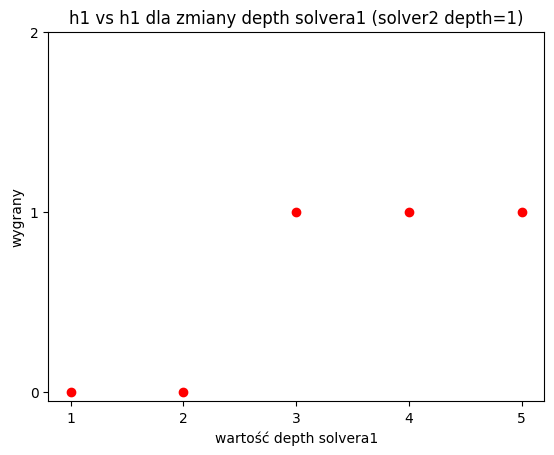

In [ ]:
make_plots([0, 0, 1, 1, 1],'wartość depth solvera1', 'h1 vs h1 dla zmiany depth solvera1 (solver2 depth=1)')

**Tabela wygranych dla różnych konfiguracji głębokości przeszukiwania przy użyciu heurystyki pierwszej**

$$
\begin{array}{|c|c|c|c|c|}
\hline
depth1/depth2 & 1 & 2 & 3 & 4 \\
\hline
1 & 0 & 2 & 0 & 2 \\
\hline
2 & 0 & 0 & 2 & 1 \\
\hline
3 & 1 & 0 & 0 & 2 \\
\hline
4 & 1 & 1 & 0 & 0 \\
\hline
\end{array}
$$

Heurystyka druga:

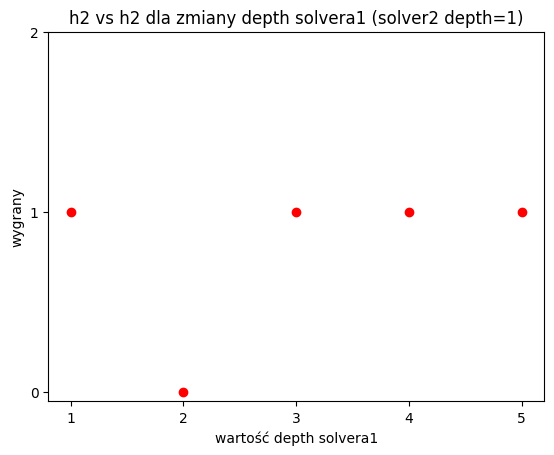

In [ ]:
make_plots([1, 0, 1, 1, 1],'wartość depth solvera1', 'h2 vs h2 dla zmiany depth solvera1 (solver2 depth=1)')

**Tabela wygranych dla różnych konfiguracji głębokości przy użyciu heurystyki drugiej**

$$
\begin{array}{|c|c|c|c|c|}
\hline
depth1/depth2 & 1 & 2 & 3 & 4 \\
\hline
1 & 1 & 1 & 2 & 2 \\
\hline
2 & 0 & 1 & 1 & 0 \\
\hline
3 & 1 & 1 & 1 & 0 \\
\hline
4 & 1 & 1 & 1 & 2 \\
\hline
\end{array}
$$

**Wyniki symulacji dla gier z dwoma symulatorami o różnej heurystyce dla zmiany głębokości przeszukiwania jednego z nich**

zmiana głębokości przeszukiwania dla symulatora pierwszego (heurystyka 1) przy depth dla solvera2 = 1 (heurystyka 2)

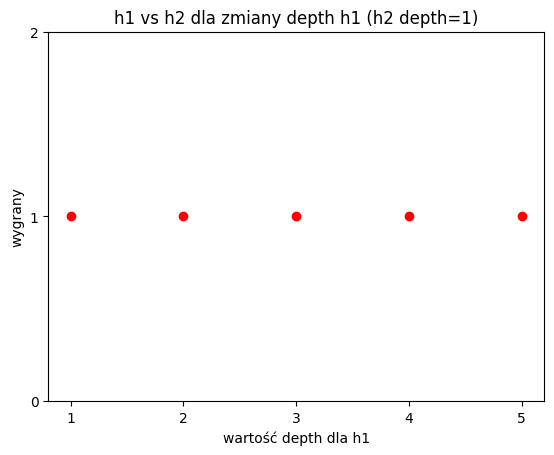

In [ ]:
make_plots([1, 1, 1, 1, 1],'wartość depth dla h1', 'h1 vs h2 dla zmiany depth h1 (h2 depth=1)')

zmiana głębokości przeszukiwania dla symulatora pierwszego przy depth dla solvera2 = 2

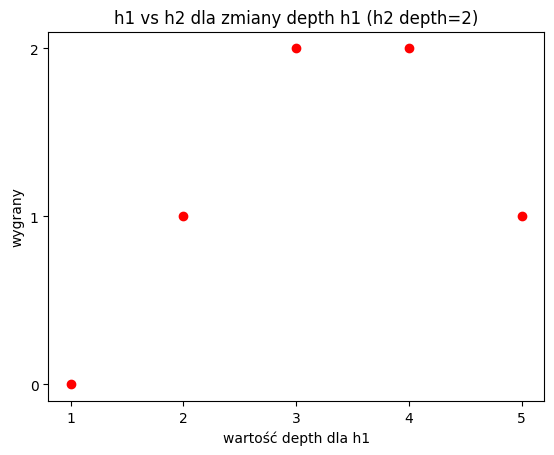

In [ ]:
make_plots([0, 1, 2, 2, 1],'wartość depth dla h1', 'h1 vs h2 dla zmiany depth h1 (h2 depth=2)')

zmiana głębokości przeszukiwania dla symulatora pierwszego przy depth dla solvera2 = 3

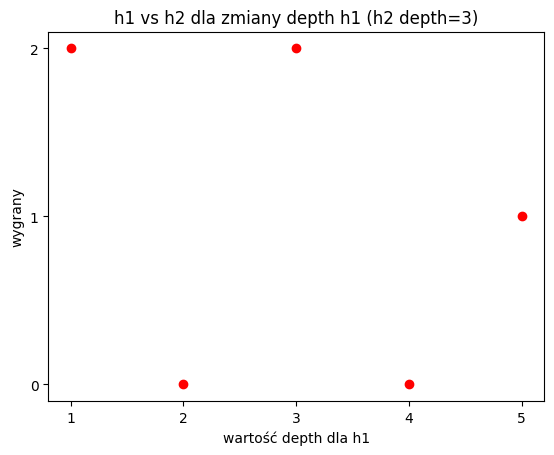

In [ ]:
make_plots([2, 0, 2, 0, 1],'wartość depth dla h1', 'h1 vs h2 dla zmiany depth h1 (h2 depth=3)')

zmiana głębokości przeszukiwania dla symulatora pierwszego przy depth dla solvera2 = 4

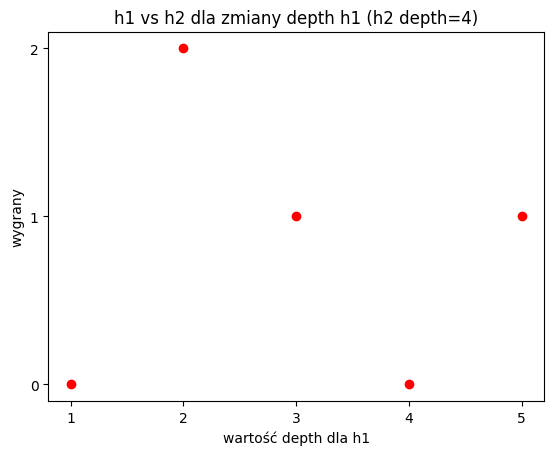

In [ ]:
make_plots([0, 2, 1, 0, 1],'wartość depth dla h1', 'h1 vs h2 dla zmiany depth h1 (h2 depth=4)')

zmiana głębokości przeszukiwania dla symulatora drugiego (heurystyka 2) przy depth dla solvera1 = 1 (heurystyka 1)

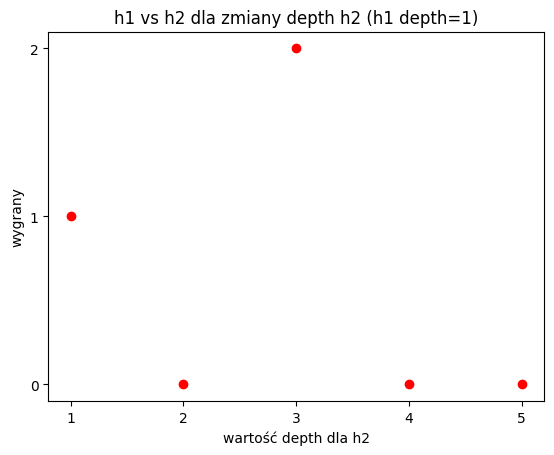

In [ ]:
make_plots([1, 0, 2, 0, 0],'wartość depth dla h2', 'h1 vs h2 dla zmiany depth h2 (h1 depth=1)')

zmiana głębokości przeszukiwania dla symulatora drugiego przy depth dla solvera1 = 2

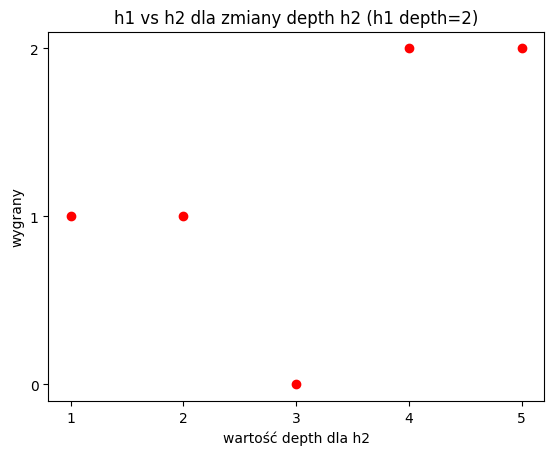

In [ ]:
make_plots([1, 1, 0, 2, 2],'wartość depth dla h2', 'h1 vs h2 dla zmiany depth h2 (h1 depth=2)')

zmiana głębokości przeszukiwania dla symulatora drugiego przy depth dla solvera1 = 3

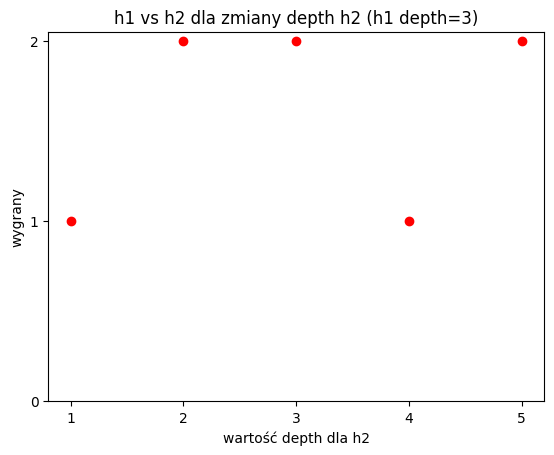

In [ ]:
make_plots([1, 2, 2, 1, 2],'wartość depth dla h2', 'h1 vs h2 dla zmiany depth h2 (h1 depth=3)')

zmiana głębokości przeszukiwania dla symulatora drugiego przy depth dla solvera1 = 4

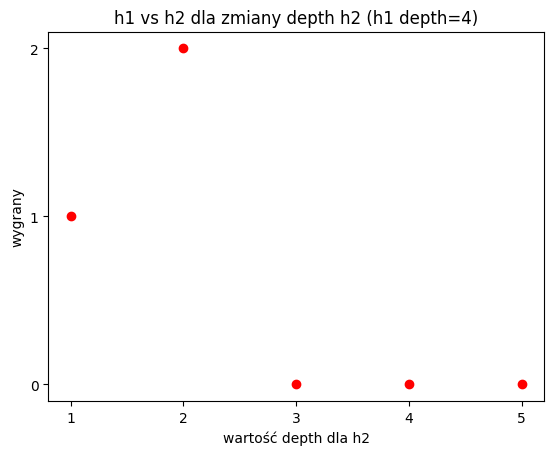

In [ ]:
make_plots([1, 2, 0, 0, 0],'wartość depth dla h2', 'h1 vs h2 dla zmiany depth h2 (h1 depth=4)')

# Wnioski

**Dwa symulatory o tej samej heurystyce**


*   **Heurystyka pierwsza**

W przypadku gdy oba symulatory korzystają z heurystyki pierwszej i mają tą samą głębokość przeszukiwań to rozgrywki kończą się remisem. Gracze przewidują ruchy przeciwnika w ten sam sposób (ta sama głębokość przeszukiwań), maksymalizując swój zysk bądź minimalizując zysk przeciwnika, przez co zawsze doprowadzają do remisu.
W przypadku zwiększania głębokości przeszukiwań dla solvera, z którego korzysta gracz pierwszy widoczne jest, że dla głębokości o 1 większej niż przeciwnik nadal gra kończy się remisem, jednak dla dalszego zwiększania, gracz pierwszy zawsze wygrywa. Dzieje się tak ponieważ większa głębokość przeszukiwań ma bezpośredni wpływ na jakość decyzji podejmowanych przez gracza. Głębsze przeszukiwanie pozwala lepiej przewidzieć przyszłe ruchy i potencjalne zagrożenia, a także rozpoznać układy wygrywające przeciwnika, które powstaną po kilku ruchach.
*   **Heurystyka druga**

W przypadku drugiej heurystyki większa zmiana głębokości przeszukiwań ma podobny skutek jak w przypadku heurystyki pierwszej (im większa głębokość przeszukiwań solvera, tym większa szansa na wygraną), jednak rezultaty gry w przypadku gdy głębokość przeszukiwań dla solvera gracza pierwszego i drugiego jest równa 1 to wygrywa gracz pierwszy. Może się tak dziać z uwagi na to, że heurystyka opiera się na przypisaniu wartości konkretnym polom planszy - gracz pierwszy ma przewagę w postaci możliwości zajęcia lepszego pola startowego.

**Dwa symulatory o różnej heurystyce**

W przypadku zmiany głębokości przeszukiwania dla symulatora pierwszego (heurystyka 1) przy głębokości przeszukiwania dla solvera2 równej 1 (heurystyka 2), gdy oba solvery mają te same głębokości to do głębokości równej 2 wygrywa solver z heurystyką pierwszą. Dzieje się tak, ponieważ jest ona lepsza w ogólnej ewaluacji planszy - bierze pod uwagę aktualne połączenia na planszy zarówno aktualnego gracza, jak i jego przeciwnika. Jednak dla głębokości 3 i więcej wygrywa gracz drugi bądź gra kończy się remisem. Może dziać się tak dlatego, że algorytm działa przy założeniu, że obaj gracze grają optymalnie - druga heurystyka nie bierze pod uwagę aktualnych połączeń na planszy i możliwe, że wykonuje ruchy nie do końca optymalne, przez co zaburza się działanie solvera z heurystyką pierwszą. Oprócz sytuacji, które mogą wynikać z nieoptymalnych ruchów, przeważa zasada, że im większa jest głębokość danego solvera tym lepiej radzi sobie w grze, ponieważ przewiduje więcej przyszłych ruchów i znajduje lepsze rozwiązania.


